<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_LangGraph_Exercise/blob/main/AI_for_BI/sql_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this SQL Agent

* After a user typed in a query, the agent is able to
  * locate the tables
  * write the SQL query to answer user's question
  * execute the SQL query and rewrite the SQL query until LLM thinks it gets the correct output

In [6]:
%%capture --no-stderr
%pip install -U langgraph langchain_openai langchain_community

In [7]:
from google.colab import userdata

# load the environment variables set in colab
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# About the Data

* This is a SQLite example database "chinook", it has multiple tables: `['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']`

In [8]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


In [9]:
from langchain_community.utilities import SQLDatabase
import pandas as pd
import pprint
import json
import ast


db = SQLDatabase.from_uri("sqlite:///Chinook.db")  # load the downloaded DB
print(db.dialect)
all_table_names = db.get_usable_table_names()
print('All the Usable Tables:', all_table_names)
print()

print('Data Sample from Table Customer:')
sample = ast.literal_eval(db.run("SELECT * FROM Customer LIMIT 5;"))
columns_query = """SELECT name FROM pragma_table_info('Customer')"""
cols = db.run(columns_query)
sample_df = pd.DataFrame(sample, columns=[col[0] for col in ast.literal_eval(cols)])
display(sample_df)

sqlite
All the Usable Tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']

Data Sample from Table Customer:


,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
2,3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
3,4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
4,5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4


In [10]:
all_table_schemas = {}
schema_cols = ['cid', 'name', 'type', 'notnull', 'default_value', 'pk']
for table_name in all_table_names:
    # Get schema data
    schema_query = f"PRAGMA table_info({table_name});"
    schema_result = db.run(schema_query)
    schema_data = ast.literal_eval(schema_result)

    # Combine column names and schema data
    schema = []
    for i, data in enumerate(schema_data):
        schema.append(dict(zip(schema_cols, data)))
    all_table_schemas[table_name] = schema

for k, v in all_table_schemas.items():
  print(k)
  print(v)
  break

Album
[{'cid': 0, 'name': 'AlbumId', 'type': 'INTEGER', 'notnull': 1, 'default_value': None, 'pk': 1}, {'cid': 1, 'name': 'Title', 'type': 'NVARCHAR(160)', 'notnull': 1, 'default_value': None, 'pk': 0}, {'cid': 2, 'name': 'ArtistId', 'type': 'INTEGER', 'notnull': 1, 'default_value': None, 'pk': 0}]


# Build Agent

### The State of the Agent

In [14]:
from typing import List
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    success_execution: bool

### Nodes & Edges

In [12]:
import re
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import tools_condition


model_str = "gpt-4o-mini-2024-07-18"

In [15]:
def extract_sql_str(raw_str):
  pattern = r"""```sql\n(.*?)\n```"""
  match = re.search(pattern, raw_str, re.DOTALL)  # re.DOTALL allows matching across lines.

  if match:
    return match.group(1).strip()  # Extract and clean the content.
  else:
    return None


def write_sql(state):
  """
    Given user's question,
      1. LLM to check whether there's available table, if not generate the answer directly.
      2. Otherwise, write the SQL query to answer user's question.
  """
  print("---WRITE SQL---")
  msgs = state["messages"]
  user_question = msgs[0].content

  model = ChatOpenAI(temperature=0, api_key=OPENAI_API_KEY,
                       model=model_str, streaming=True)
  prompt = [
      SystemMessage(content="You are a SQL expert able to write SQL queries to answer user's questions."),
      HumanMessage(
          content=f""" \n
                  Given every table's schema in the database: {all_table_schemas} \n
                  and here's user's question: {user_question} \n
                  if there's no available table to answer the user question, output 'No table found' \n
                  otherwise, output the SQL query to answer user's question: """,
      )
  ]
  result = model.invoke(prompt).content
  if 'No table found' in result:
    output = 'No table found'
  else:
    output = extract_sql_str(result)

  return {"messages": [output]}


def execute_sql(state):
  """
    Execute the generated SQL query.
  """
  print("---EXECUTE SQL---")
  generated_sql = state["messages"][-1].content

  try:
    result = db.run(generated_sql)
    return {"messages": [result],
            "success_execution": True}
  except:
    print('SQL Execution Error')
    return {"messages": [generated_sql],
            "success_execution": False}


def rewrite_sql(state):
  """
    Rewrite the generated SQL query.
  """
  print("---REWRITE SQL---")
  msgs = state["messages"]
  error_sql = msgs[-1].content
  user_question = msgs[0].content

  model = ChatOpenAI(temperature=0, api_key=OPENAI_API_KEY,
                       model=model_str, streaming=True)
  prompt = [
      SystemMessage(content="You are a SQL expert able to write SQL queries to answer user's questions."),
      HumanMessage(
          content=f""" \n
                  Given every table's schema in the database: {all_table_schemas} \n
                  and here's user's question: {user_question}. \n
                  Previously written SQL {error_sql} got execution error \n
                  please rewrite a correct SQL query to answer user's question: """,
      )
  ]
  rewritten_sql = extract_sql_str(model.invoke(prompt).content)

  return {"messages": [rewritten_sql]}


def output_answer(state):
  """
    Output the final results
  """
  print("---OUTPUT ANSWER---")
  msgs = state["messages"]
  final_output = msgs[-1].content

  return {"messages": [final_output]}

### Build Graph

In [16]:
from langgraph.graph import END, StateGraph, START

# define a new graph
workflow = StateGraph(AgentState)

# add nodes
workflow.add_node("write_sql", write_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("rewrite_sql", execute_sql)
workflow.add_node("output_answer", output_answer)

# add edges
workflow.add_edge(START, "write_sql")
workflow.add_conditional_edges(
    "write_sql",
    lambda state: "No table found" not in state["messages"][-1].content,
    {False: "output_answer", True: "execute_sql"}
)
workflow.add_conditional_edges(
    "execute_sql",
    lambda state: state["success_execution"],
    {False: "rewrite_sql", True: "output_answer"}
)
workflow.add_edge("rewrite_sql", "execute_sql")

# compile
graph = workflow.compile()

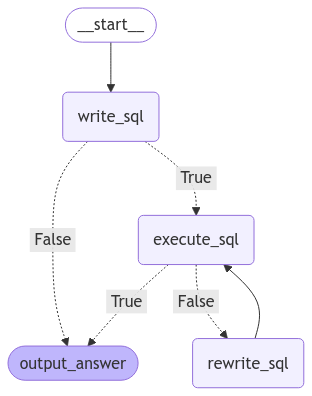

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Run SQL Agent

In [18]:
import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.errors import GraphRecursionError


def run_graph(inputs):
  graph_config = RunnableConfig(recursion_limit=5)  # stop if the cycle happened 5 times still can't hit END
  try:
    for output in graph.stream(inputs, config = graph_config):
      for key, value in output.items():
          pprint.pprint(f"Output from node '{key}':")
          pprint.pprint(value, indent=2, width=80, depth=None)
  except GraphRecursionError as e:
    print()
    print("Can't find the answer")

In [19]:
inputs = {
    "messages": [
        ("user", """Find me the unique number of customers and artists,
                    output as a table with column names?"""),
    ]
}
run_graph(inputs)

---WRITE SQL---
"Output from node 'write_sql':"
{ 'messages': [ 'SELECT \n'
                "    'Customers' AS Category, \n"
                '    COUNT(DISTINCT CustomerId) AS UniqueCount \n'
                'FROM \n'
                '    Customer\n'
                'UNION ALL\n'
                'SELECT \n'
                "    'Artists' AS Category, \n"
                '    COUNT(DISTINCT ArtistId) AS UniqueCount \n'
                'FROM \n'
                '    Artist;']}
---EXECUTE SQL---
"Output from node 'execute_sql':"
{ 'messages': ["[('Customers', 59), ('Artists', 275)]"],
  'success_execution': True}
---OUTPUT ANSWER---
"Output from node 'output_answer':"
{'messages': ["[('Customers', 59), ('Artists', 275)]"]}


In [20]:
inputs = {
    "messages": [
        ("user", "How's the weather tomorrow?"),
    ]
}
run_graph(inputs)

---WRITE SQL---
"Output from node 'write_sql':"
{'messages': ['No table found']}
---OUTPUT ANSWER---
"Output from node 'output_answer':"
{'messages': ['No table found']}
